## Introduction

In this notebook we probe into the ViT attention weights.

In [1]:
!pip install --upgrade gdown -qq
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt -O ilsvrc2012_wordnet_lemmas.txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
--2022-04-06 04:59:21--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2022-04-06 04:59:21 (55.8 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



## Imports and Setups

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import requests
import zipfile
import gdown
import cv2

## Chose the ViT model

In [3]:
model_name = "dino_base_patch16_224"

model_handle_map ={
    "vit_base_i1k_patch16_224": "1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ",
    "vit_base_i21k_patch16_224": "1ApOdYe4NXxhPhJABefgZ3KVvqsQzhCL7",
    "dino_base_patch16_224":"16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN",
    "deit_base_patch16_224": "https://tfhub.dev/sayakpaul/deit_base_patch16_224/1",
    "deit_base_distilled_patch16_224": "https://tfhub.dev/sayakpaul/deit_base_distilled_patch16_224/1",
}

# Derive the patch size, image resolution, and class tokens from the model name.
splits = model_name.split("_")
model_type = splits[0]
input_resolution = int(splits[-1])
patch_size = int(splits[-2].replace("patch", ""))
num_cls_tokens = 2 if "distilled" in model_name else 1

# Get the model handle.
model_handle = model_handle_map[model_name]

print(f"Patch Size: {patch_size}.")
print(f"Input resolution: {input_resolution} x {input_resolution} x 3.")
print(f"TF-Hub handle OR Drive ID: {model_handle}.")
print(f"Number of class tokens: {num_cls_tokens}.")
print(f"Model type: {model_type}")

Patch Size: 16.
Input resolution: 224 x 224 x 3.
TF-Hub handle OR Drive ID: 16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN.
Number of class tokens: 1.
Model type: dino


## Preprocessing the test image

In [4]:
crop_layer = keras.layers.CenterCrop(input_resolution, input_resolution)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1./127.5, offset=-1)


def preprocess_image(image, size=input_resolution):
    # turn the image into a numpy array and add batch dim
    image = np.array(image)
    image = tf.expand_dims(image, 0)
    
    # if model type is vit rescale the image to [-1, 1]
    if model_type == "vit":
        image = rescale_layer(image)

    # resize the image using bicubic interpolation
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(
        image,
        (resize_size, resize_size),
        method="bicubic"
    )

    # crop the image
    image = crop_layer(image)

    # if model type is deit normalize the image
    if model_type != "vit":
        image = norm_layer(image)
    
    # return the image
    return image.numpy()
    

def load_image_from_url(url):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image)
    return image, preprocessed_image

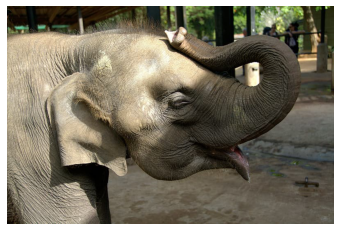

In [5]:
with open("ilsvrc2012_wordnet_lemmas.txt", "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://p0.pikrepo.com/preview/853/907/close-up-photo-of-gray-elephant.jpg"
image, preprocessed_image = load_image_from_url(img_url)

plt.imshow(image)
plt.axis("off")
plt.show()

## Run inference

In [6]:
def get_tfhub_model(model_url: str) -> tf.keras.Model:
    inputs = tf.keras.Input((input_resolution, input_resolution, 3))
    hub_module = hub.KerasLayer(model_url)
    outputs, attention_weights = hub_module(inputs)
    return tf.keras.Model(inputs, outputs=[outputs, attention_weights])


def get_gdrive_model(model_id: str) -> tf.keras.Model:
    model_path = gdown.download(id=model_id, quiet=False)
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall()
    model_name = model_path.split(".")[0]
    inputs = tf.keras.Input((input_resolution, input_resolution, 3))
    model = tf.keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs)
    return tf.keras.Model(inputs, outputs=[outputs, attention_weights])

In [7]:
if len(model_handle.split("/")) > 1:
    loaded_model = get_tfhub_model(model_handle)
else:
    loaded_model = get_gdrive_model(model_handle)

Downloading...
From: https://drive.google.com/uc?id=16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN
To: /content/vit_dino_base16.zip
100%|██████████| 326M/326M [00:01<00:00, 190MB/s]


In [8]:
predictions, attention_score_dict = loaded_model.predict(preprocessed_image)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)

Indian_elephant, Elephas_maximus


## Probing into the attention weights

Reference: https://colab.research.google.com/github/sayakpaul/deit-tf/blob/main/notebooks/classification.ipynb

In [9]:
# Stack the individual attention matrices from individual transformer blocks.
attn_mat = tf.stack([attention_score_dict[k] for k in attention_score_dict.keys()])
attn_mat = tf.squeeze(attn_mat, axis=1)
print(attn_mat.shape)

# Average the attention weights across all heads.
attn_mat = tf.reduce_mean(attn_mat, axis=1)
print(attn_mat.shape)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_attn = tf.eye(attn_mat.shape[1])
aug_attn_mat = attn_mat + residual_attn
aug_attn_mat = aug_attn_mat / tf.reduce_sum(aug_attn_mat, axis=-1)[..., None]
aug_attn_mat = aug_attn_mat.numpy()
print(aug_attn_mat.shape)

# Recursively multiply the weight matrices
joint_attentions = np.zeros(aug_attn_mat.shape)
joint_attentions[0] = aug_attn_mat[0]

for n in range(1, aug_attn_mat.shape[0]):
    joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
result = (mask * image).astype("uint8")
print(result.shape)

(12, 12, 197, 197)
(12, 197, 197)
(12, 197, 197)
(533, 800, 3)


## Visualize the attention maps

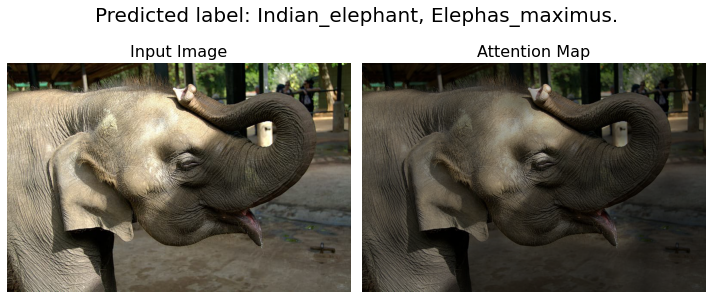

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8))
fig.suptitle(f"Predicted label: {predicted_label}.", fontsize=20)

_ = ax1.imshow(image)
_ = ax2.imshow(result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()

## Mean Attention Distance

Reference: https://gist.github.com/simonster/155894d48aef2bd36bd2dd8267e62391

### Compute Mean Distance
![Compute Mean Distance](https://i.imgur.com/nyuS9H9.png)

In [11]:
def compute_distance_matrix(patch_size, num_patches, length):
    """Helper function to compute distance matrix."""
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j: # zero distance
                continue

            xi, yi = (int(i/length)), (i % length)
            xj, yj = (int(j/length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix

def compute_mean_attention_dist(patch_size, attention_weights):
    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[..., num_cls_tokens:, num_cls_tokens:] # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert (length**2 == num_patches), ("Num patches is not perfect square")

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(mean_distances, axis=-1) # sum along last axis to get average distance per token
    mean_distances = np.mean(mean_distances, axis=-1) # now average across all the tokens

    return mean_distances

In [12]:
# Build the mean distances for every transformer block
mean_distances = {
    f"{name}_mean_dist": compute_mean_attention_dist(patch_size=patch_size, attention_weights=attention_weight)
    for name, attention_weight in attention_score_dict.items()
}

In [13]:
# Get the number of heads from the mean distance output
num_heads = tf.shape(mean_distances["transformer_block_0_att_mean_dist"])[-1].numpy()

# Print the shapes
print(f"Num Heads: {num_heads}")

Num Heads: 12


## Visualize the mean distances

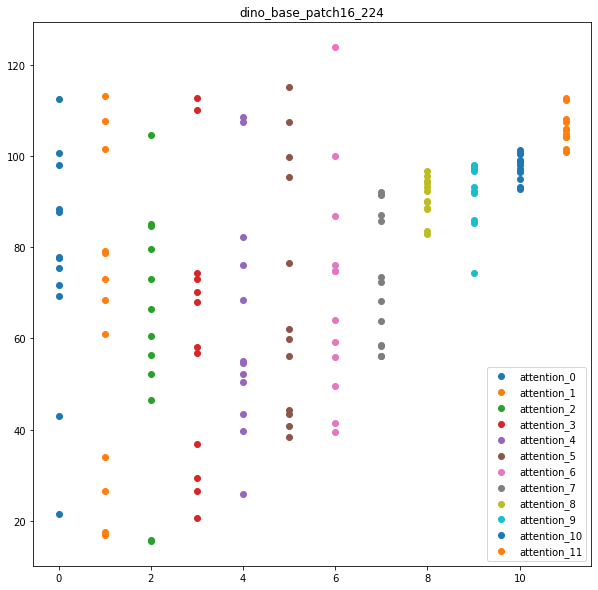

In [14]:
plt.figure(figsize=(10, 10))

for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]
    x = [idx] * num_heads
    y = mean_distance[0, :]
    plt.scatter(x=x, y=y, label=f"attention_{idx}")

plt.legend(loc="lower right")
plt.title(model_name)
plt.show()